In [172]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from copy import copy

from collections import Counter
from mord import LogisticAT
import math
from matplotlib.offsetbox import AnchoredText
from os import listdir
import sys
sys.path.append('functions.py')
%run functions.py
%run ml_functions.py

In [173]:
def expandTimepoints(data, mapping, should_encode = False):
    expanded_time = pd.DataFrame()
    for host_name in np.unique(mapping.host_name):
        df_small = data.loc[mapping.host_name == host_name, :]
        if should_encode:
            df_small = encode(df_small, autoencoder_16s)
        expanded_timepoints = df_small.to_numpy().reshape((1, 3*df_small.shape[1]))[0]
        expanded_time = expanded_time.append(pd.Series(expanded_timepoints), ignore_index = True)
    expanded_time.index = np.unique(mapping.host_name)
    return(expanded_time)

x_16s, map_16s = get16sData(filt = False)
x_16s = x_16s + 1
exp_16s = expandTimepoints(x_16s, map_16s)

(453, 5265)


In [174]:
x_embed, map_embed = getEmbedded16s()
x_mtg,  map_mtg = getMtgData(filt = False)
x_mtg = x_mtg + 1
x_mtt, map_mtt = getMttData(filt = False)
x_mtt = x_mtt + 1
x_mbx, map_mbx = getMetabolData()
x_mbx = x_mbx + 1
x_mbx_filt = filterForProkaryotes(x_mbx)
x_mbx_filt = x_mbx_filt + 1

x_16s = x_16s.groupby(map_16s.host_name).mean()
x_embed = x_embed.groupby(map_embed.host_name).mean()
x_mtg = x_mtg.groupby(map_mtg.host_name).mean()
x_mtt = x_mtt.groupby(map_mtt.host_name).mean()
x_mbx = x_mbx.groupby(map_mbx.host_name).mean()
x_mbx_filt = x_mbx_filt.groupby(map_mbx.host_name).mean()
samples_keep = combineOmics(x_16s, x_mtg, x_mtt, x_mbx)

x_16s = x_16s.loc[samples_keep, :]
x_embed = x_embed.loc[samples_keep, :]
x_mtg = x_mtg.loc[samples_keep, :]
x_mtt = x_mtt.loc[samples_keep, :]
x_mbx = x_mbx.loc[samples_keep, :]
x_mbx_filt = x_mbx_filt.loc[samples_keep, :]
all_omics = pd.concat([x_16s, x_mtg, x_mtt, x_mbx], axis = 1)

map_16s = formatMapping(map_16s, samples_keep)
map_mtg = formatMapping(map_mtg, samples_keep)
map_mtt = formatMapping(map_mtt, samples_keep)
map_mbx = formatMapping(map_mbx, samples_keep)


(177, 56)


In [175]:
autoencoder_16s = "weights/autoencoder/16s/braycurtis/500dim/ep6700_train0.000_val0.000.hdf5"
autoencoder_mtg = "weights/autoencoder/mtg/braycurtis/500dim/ep6000_train0.000_val0.000.hdf5"
autoencoder_mtt = "weights/autoencoder/mtt/braycurtis/500dim/ep8700_train0.001_val0.021.hdf5"
autoencoder_mbx = "weights/autoencoder/metabol/braycurtis/500dim/ep6300_train0.004_val0.129.hdf5"
autoencoder_mbx_filt = "weights/autoencoder/metabol/filt/braycurtis/50dim/ep1830_train0.143_val0.631.hdf5"

encoded_16s = x_embed
encoded_mtg = encode(x_mtg, autoencoder_mtg)
encoded_mtt = encode(x_mtt, autoencoder_mtt)
encoded_mbx = encode(x_mbx, autoencoder_mbx)
encoded_mbx_filt = encode(x_mbx_filt, autoencoder_mbx_filt)

all_omics_encoded = pd.concat([encoded_16s, encoded_mtg, encoded_mtt, encoded_mbx], axis = 1)

In [176]:
#all values should be 1
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)
def checkMatch(data1, data2):
    print(np.sum([i == j for i,j in zip(data1.index.values, data2.index.values)]) / data1.shape[0])
    
checkMatch(x_16s, map_16s)
checkMatch(x_mtg, map_mtg)
checkMatch(x_mtt, map_mtt)
checkMatch(encoded_16s, map_16s)
checkMatch(encoded_mtg, map_mtg)
checkMatch(encoded_mtt, map_mtt)

1.0
1.0
1.0
1.0
1.0
1.0


In [177]:
def dropLowStd(data):
    return(data.loc[:, np.std(data, axis = 0) > 0])

def normalize(data):
    return((data - np.mean(data, axis = 0)) / (np.var(data, axis = 0)))

def logTransform(data):
    return(np.log(data + 1))

In [178]:
%run ml_functions.py
%run functions.py
data_storage = Storage([x_16s, x_mtg, x_mtt, x_mbx, all_omics])
encoded_storage = Storage([encoded_16s, encoded_mtg, encoded_mtt, encoded_mbx, all_omics_encoded])
mapping_storage = Storage([map_16s, map_mtg, map_mtt, map_mtt, map_mtt])
data_storage.applyFunction(dropLowStd)
encoded_storage.applyFunction(dropLowStd)
data_storage.applyFunction(scale)
encoded_storage.applyFunction(scale)
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)


c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\ctata\miniconda3\envs\tf\lib\site-packages\sklearn\preprocess

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


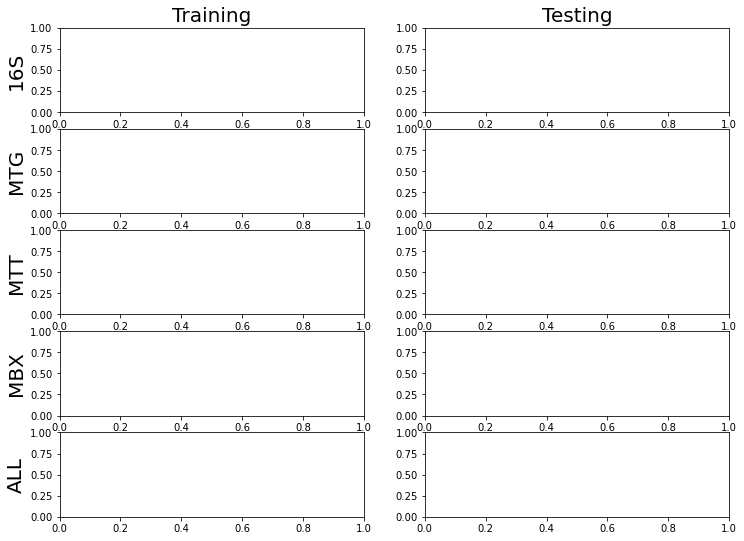

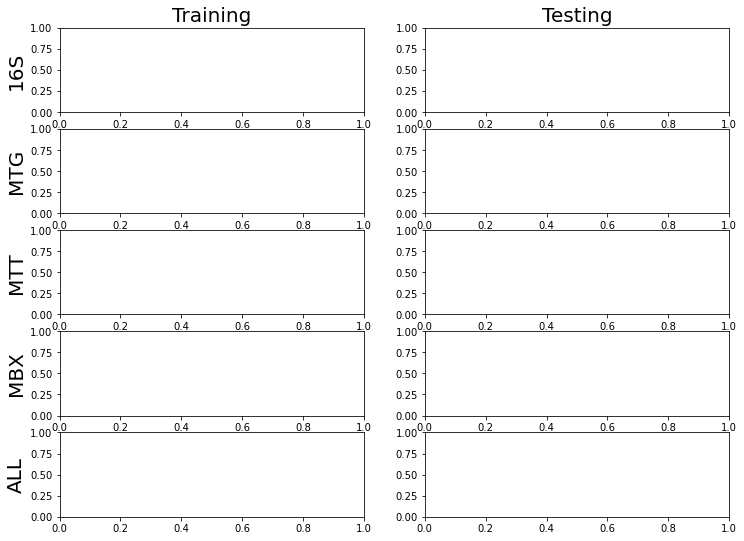

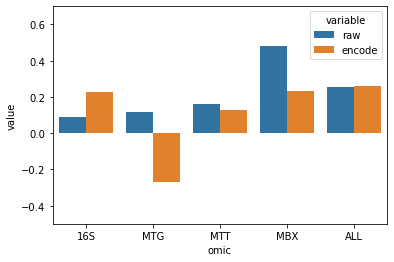

In [179]:
%run ml_functions.py
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "fruit", "rf", transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


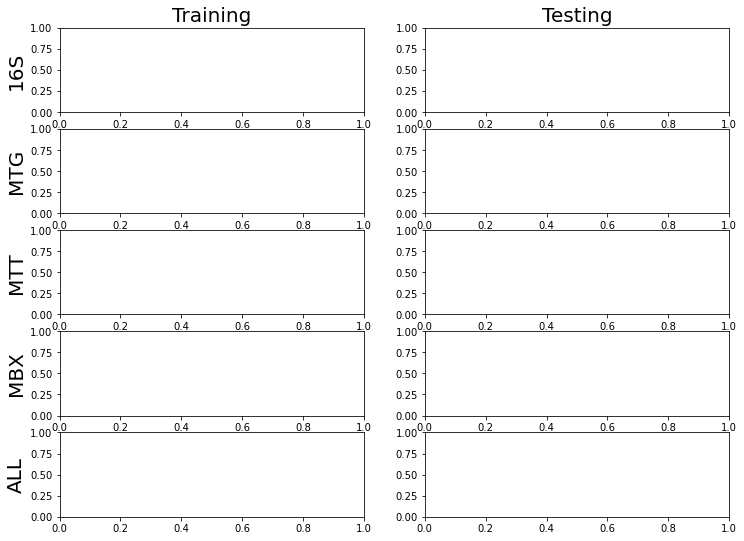

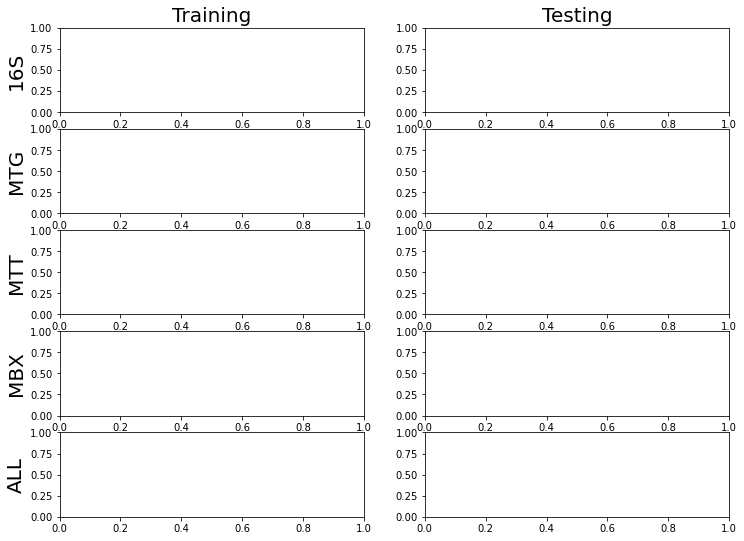

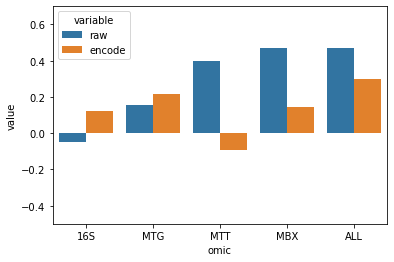

In [180]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "dairy", 'rf', transformOrdinal_fruit)


('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


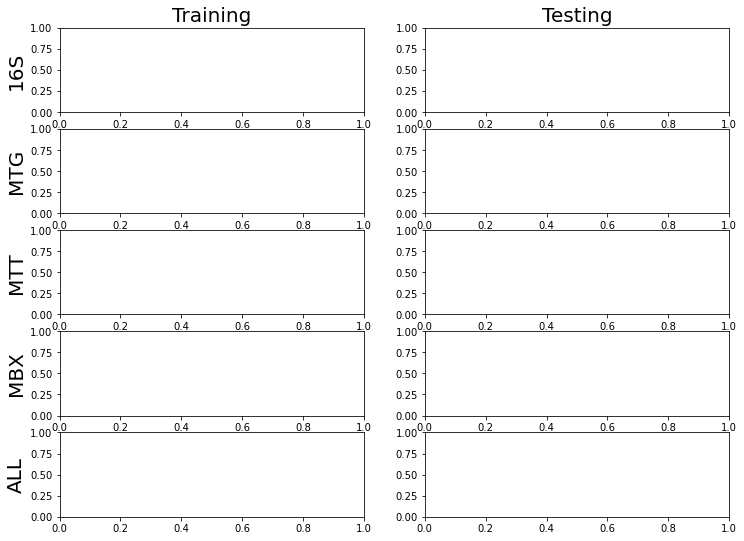

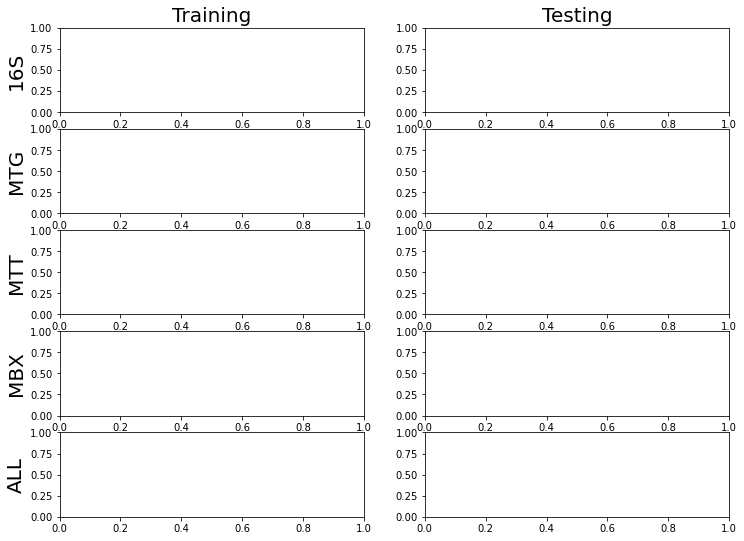

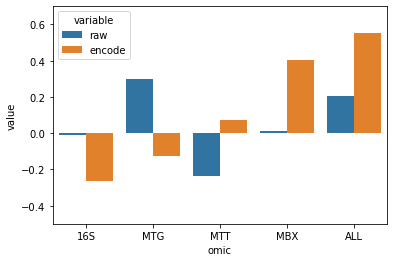

In [181]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'multivitamin', 'rf', transform = None)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


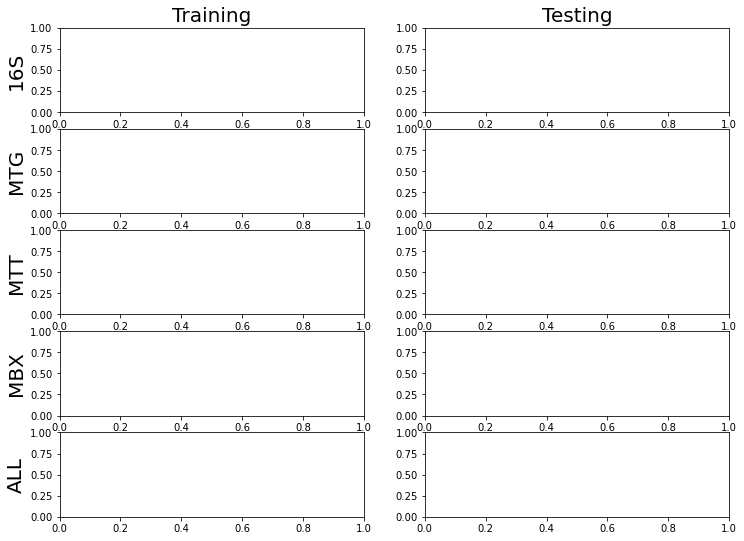

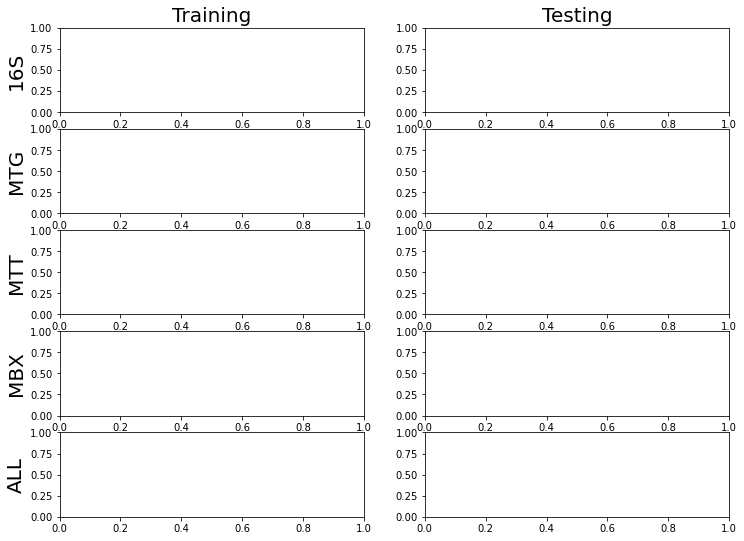

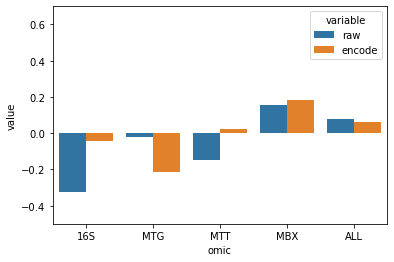

In [182]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool, 
                                              'olive_oil',  'rf', transform = transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


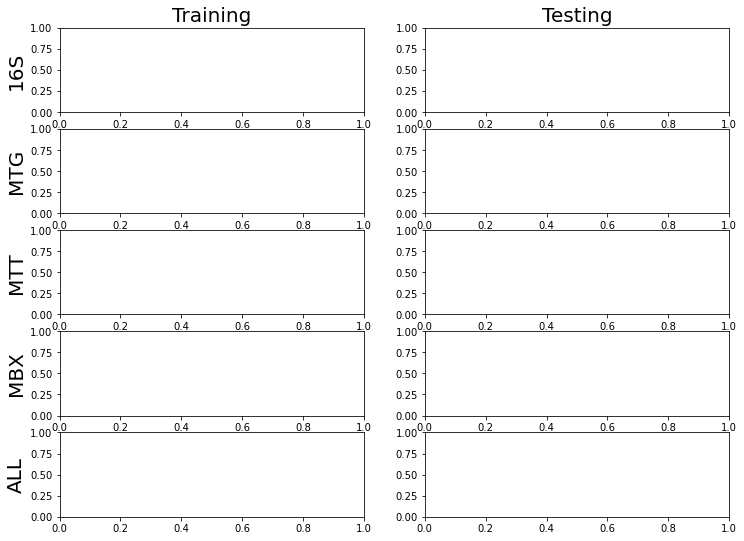

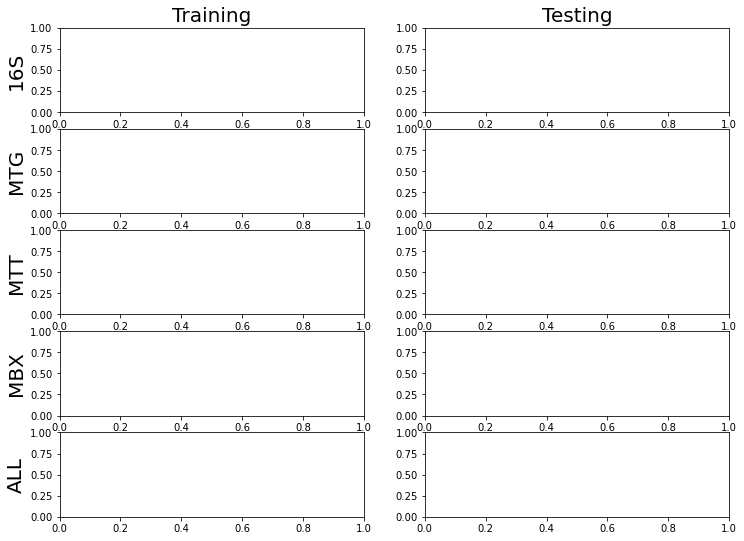

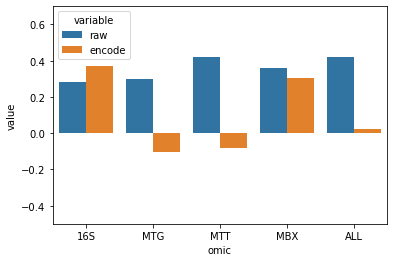

In [183]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'vegetable', 'rf', transform = transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


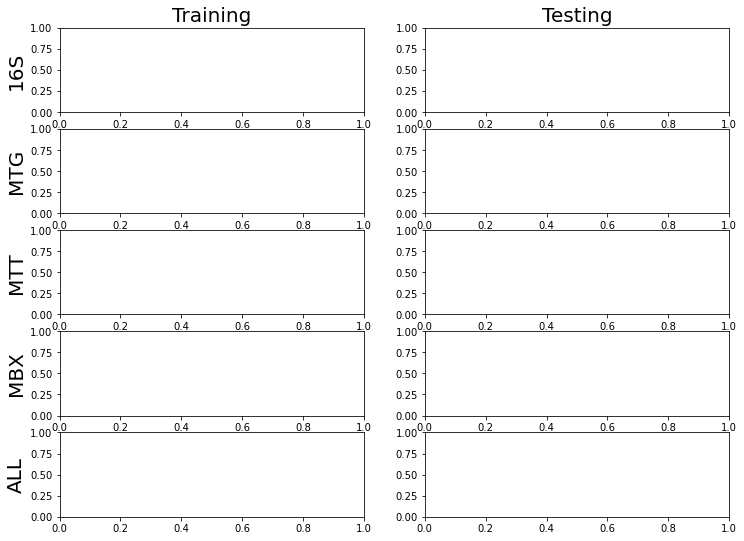

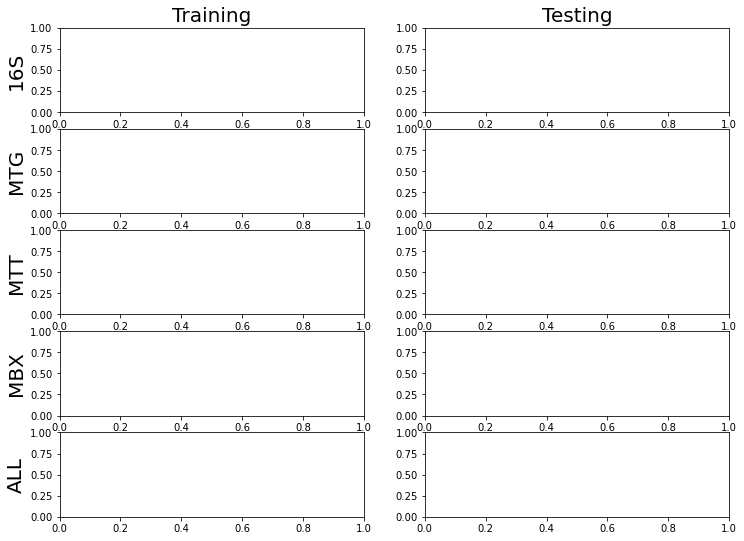

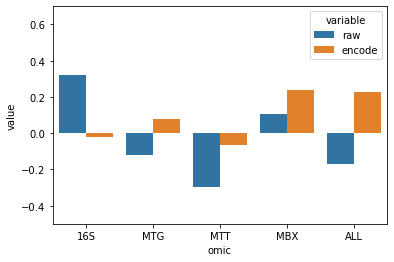

In [184]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'probiotic', 'rf', transform = transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


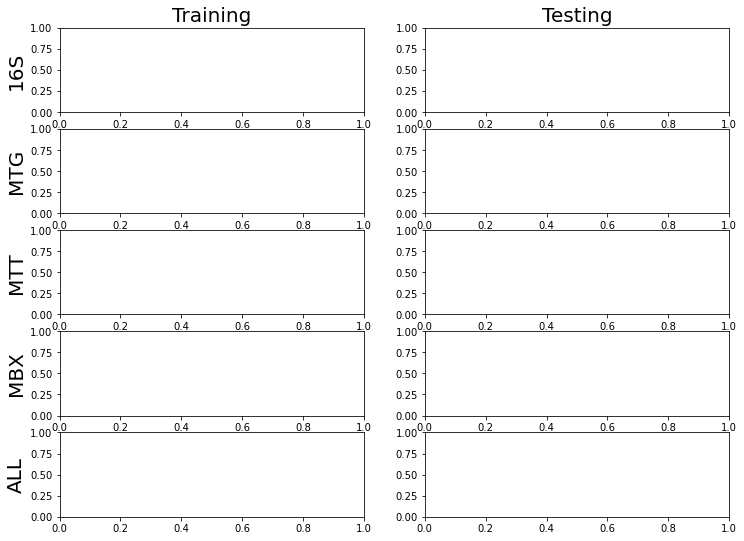

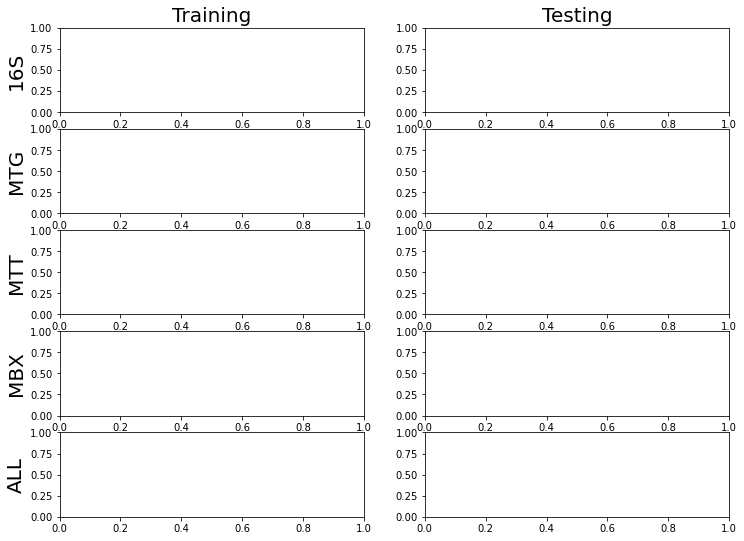

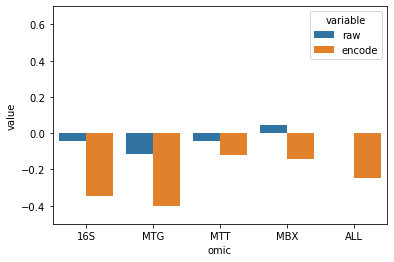

In [185]:
for i in np.arange(len(mapping_storage.getList())):
    mapping_storage.getList()[i].phenotype = [True if i == 'A' else False for i in mapping_storage.getList()[i].phenotype]
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool, 
                                              'phenotype', 'rf', transform = None)

# Sqrt and centered

In [186]:
%run ml_functions.py
#%run functions.py
data_storage = Storage([x_16s, x_mtg, x_mtt, x_mbx, all_omics])
encoded_storage = Storage([encoded_16s, encoded_mtg, encoded_mtt, encoded_mbx, all_omics_encoded])
mapping_storage = Storage([map_16s, map_mtg, map_mtt, map_mtt, map_mtt])
data_storage.applyFunction(dropLowStd)
encoded_storage.applyFunction(dropLowStd)
data_storage.applyFunction(normalize)
#encoded_storage.applyFunction(np.sqrt)
encoded_storage.applyFunction(normalize)
train_bool, test_bool = splitDatasets(x_16s, map_16s, return_bool= True, state = 1)


('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


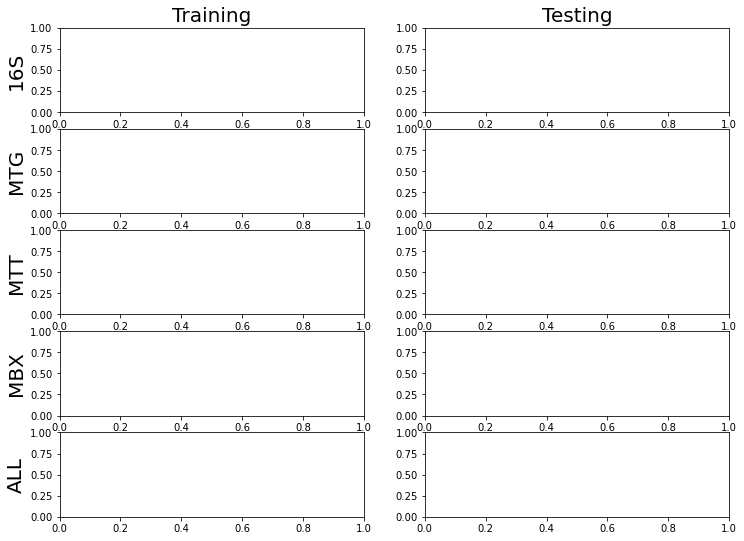

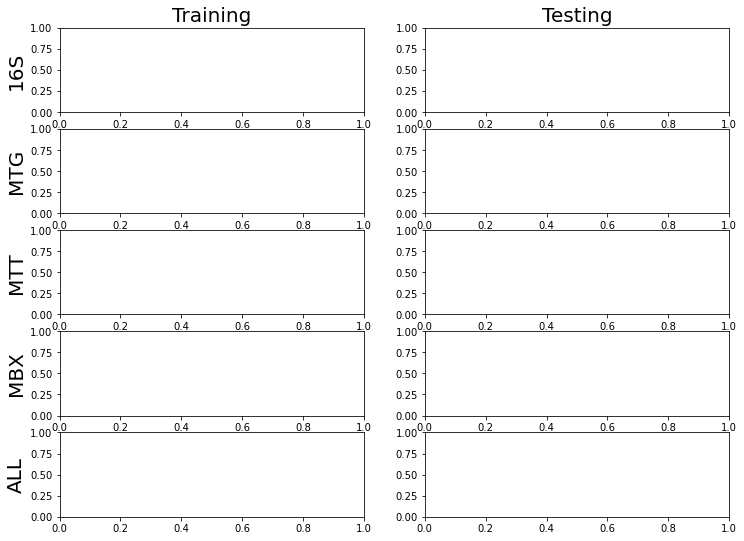

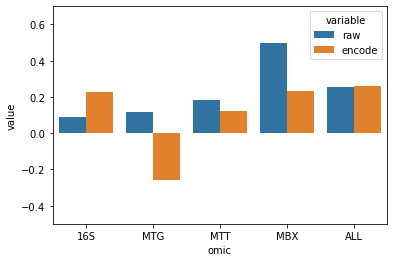

In [187]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "fruit", 'rf', transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


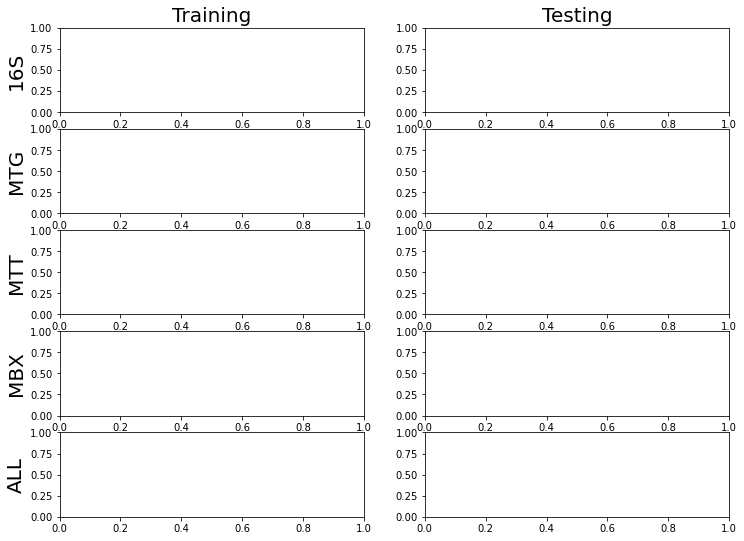

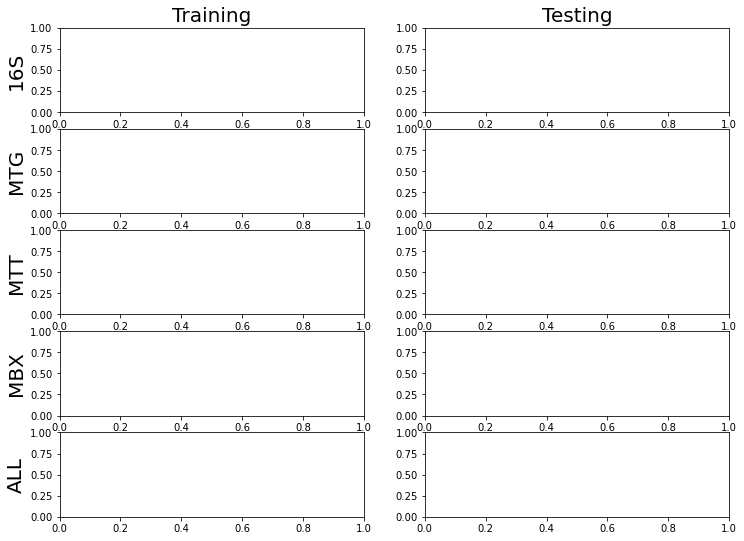

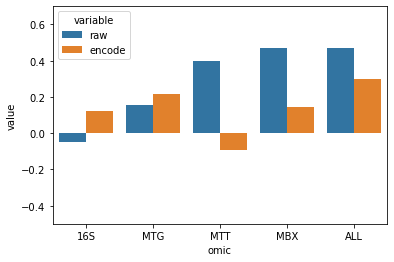

In [188]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              "dairy", 'rf', transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


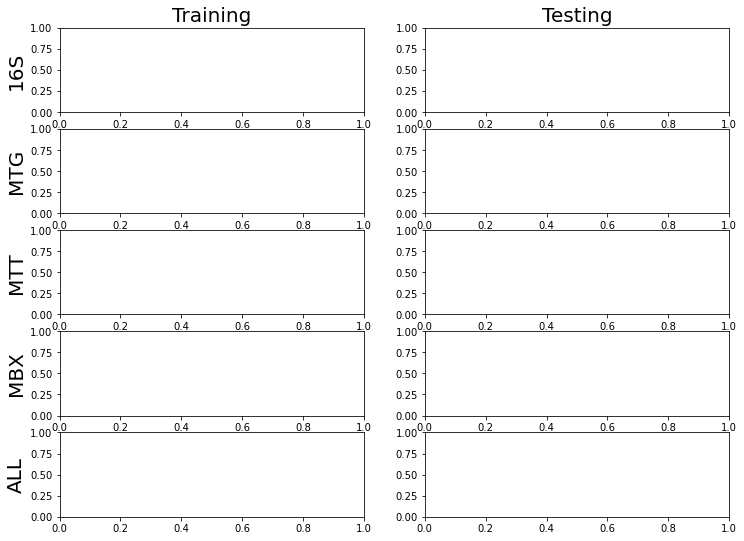

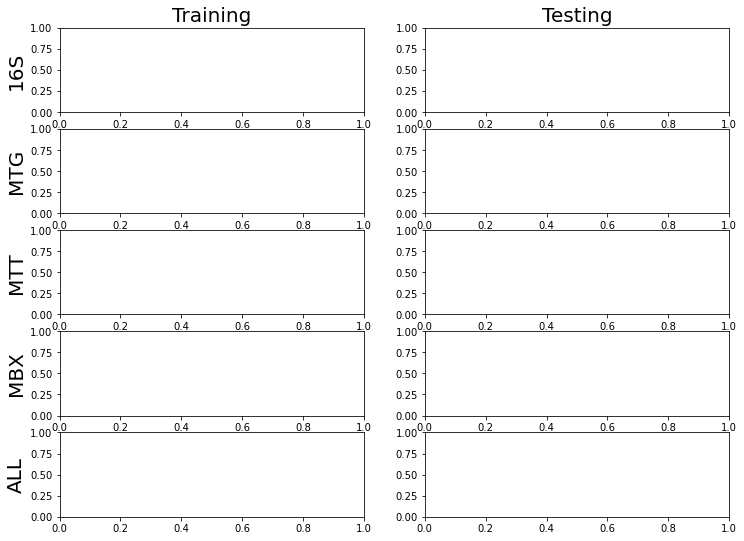

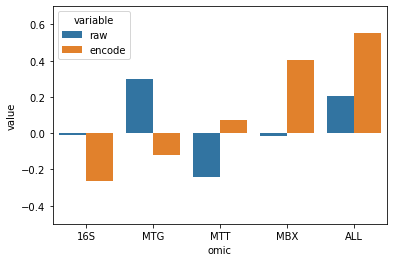

In [189]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'multivitamin', 'rf', transform = None)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


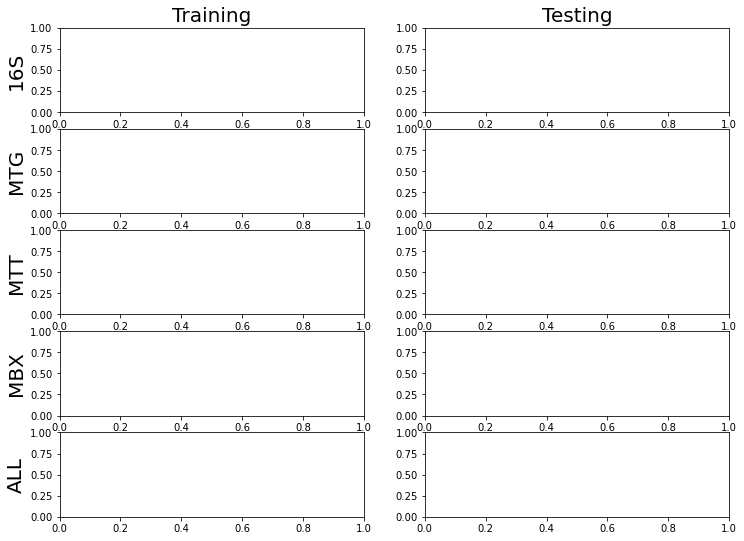

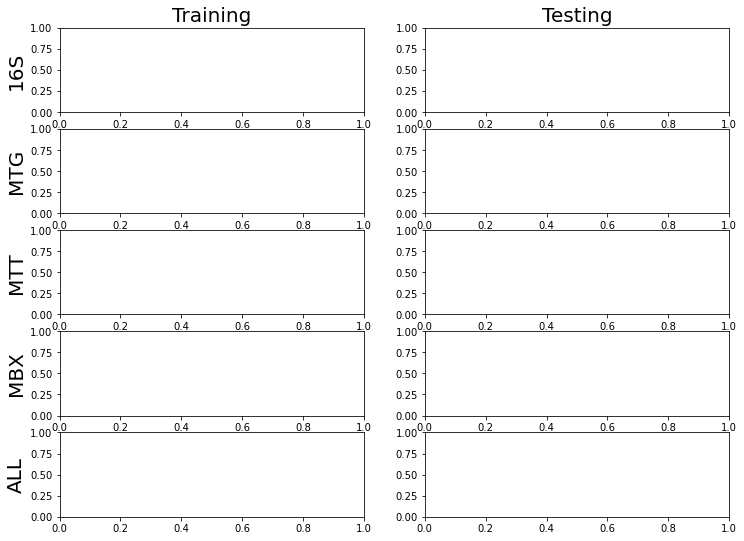

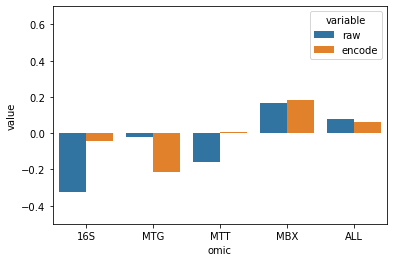

In [190]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'olive_oil', 'rf', transform = transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


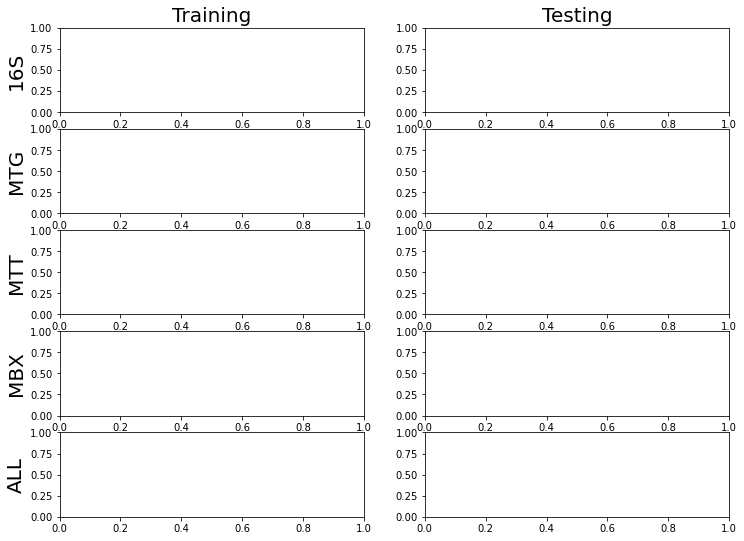

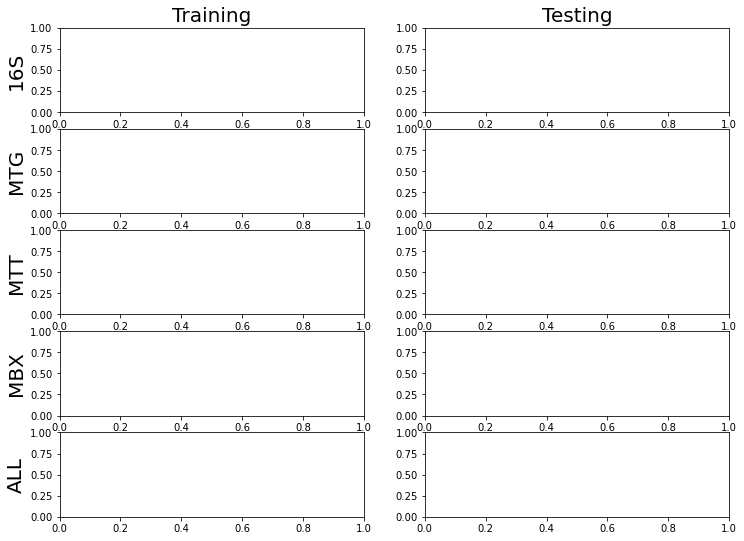

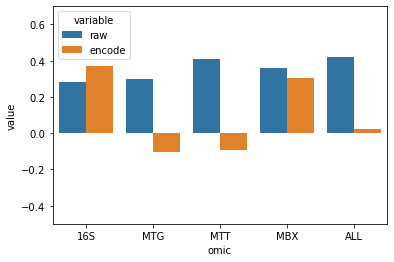

In [191]:
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'vegetable', 'rf', transform = transformOrdinal_fruit)


('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


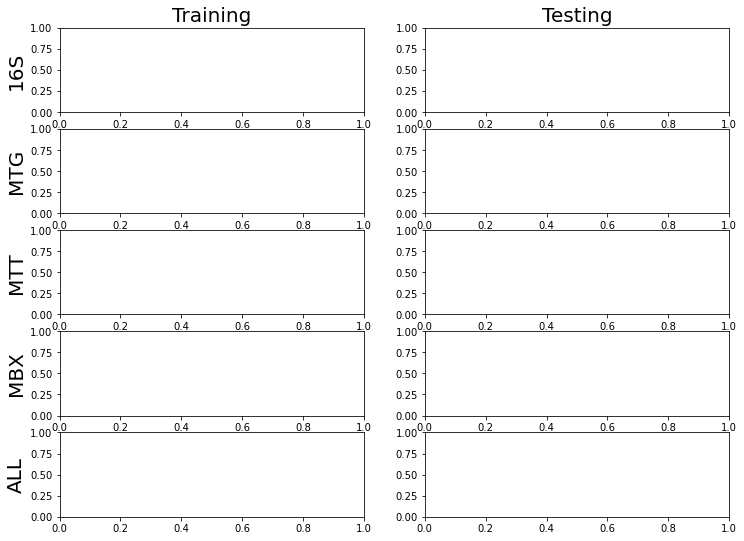

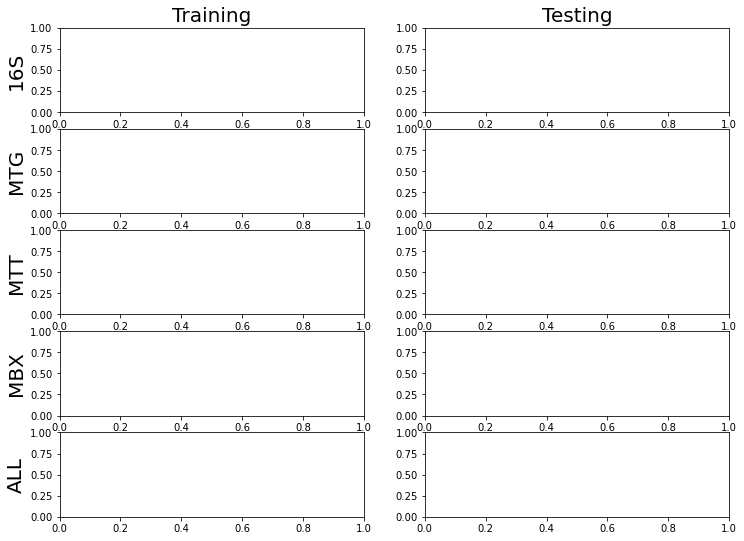

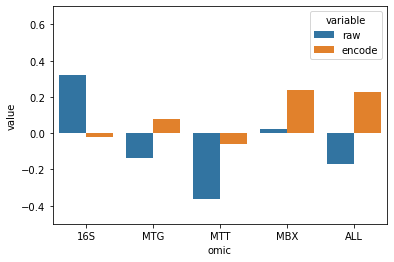

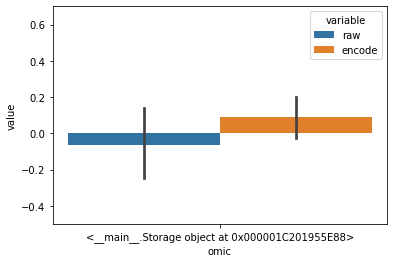

In [192]:

res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool, 
                                              'probiotic', 'rf', transform = transformOrdinal_fruit)

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


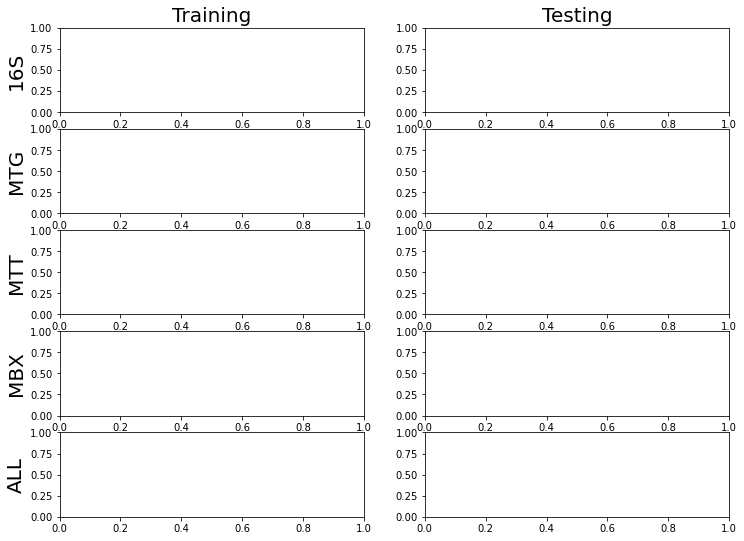

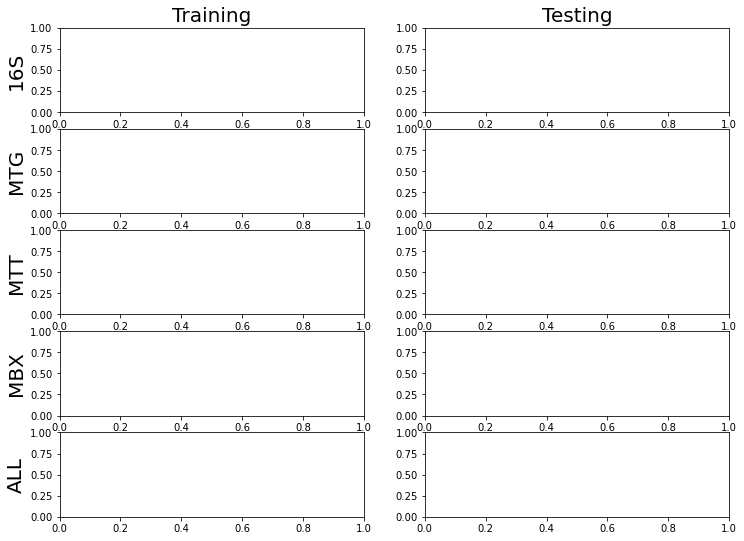

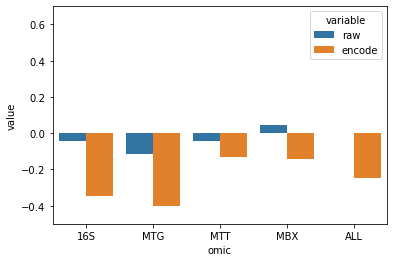

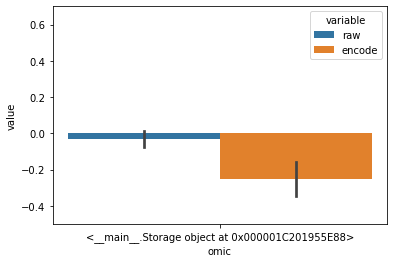

In [193]:
for i in np.arange(len(mapping_storage.getList())):
    mapping_storage.getList()[i].phenotype = [True if i == 'A' else False for i in mapping_storage.getList()[i].phenotype]
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool, 
                                              'phenotype', model_type = "rf", transform = None)